Plan:
    -   Select stock (e.g., AAPL, MSFT, TSLA, AZN.L) from NASDAQ or FTSE 100.
    -   Collect historical price data via yfinance (include also OHLCV, technical indicators like SMA/RSI/MACD)
    -   Prediction -> Time series regression via sliding window 
    -   Model = LSTM (form of RNN) via PyTorch (reduces vanishing gradient)
    -   Train test split 
    -   Performance metrics: RMSE, MAE, Directional Accuracy (compare against 50%), matplotlib 

Report topics:
-   Choice of stock: Nike
-   Time range is 10 years to cover multiple market cycles.
-   Making a dataframe (df) from the yfinance data for NKE
-   2D df vs. 1D df for the MinMaxScaler
-   Data shaping process for LSTM (X -> 2D -> 3D, Y -> 1D)


In [15]:
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
ticker = "NKE"

start_date = "2015-01-01"
end_date = "2025-06-27"

df = yf.download(ticker, start=start_date, end=end_date)

df.tail()

/var/folders/_7/69kr54014yz4gsmldjnd3kp40000gn/T/ipykernel_57036/3121837813.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NKE,NKE,NKE,NKE,NKE
Date,,,,,
2025-06-20,59.790001,60.040001,59.189999,59.750000,19084000
2025-06-23,60.779999,61.299999,59.439999,59.580002,15921300
2025-06-24,61.419998,61.980000,60.480000,61.330002,12564000
2025-06-25,60.830002,61.529999,60.360001,61.450001,12186200
2025-06-26,62.540001,62.730000,60.820000,61.560001,37225300


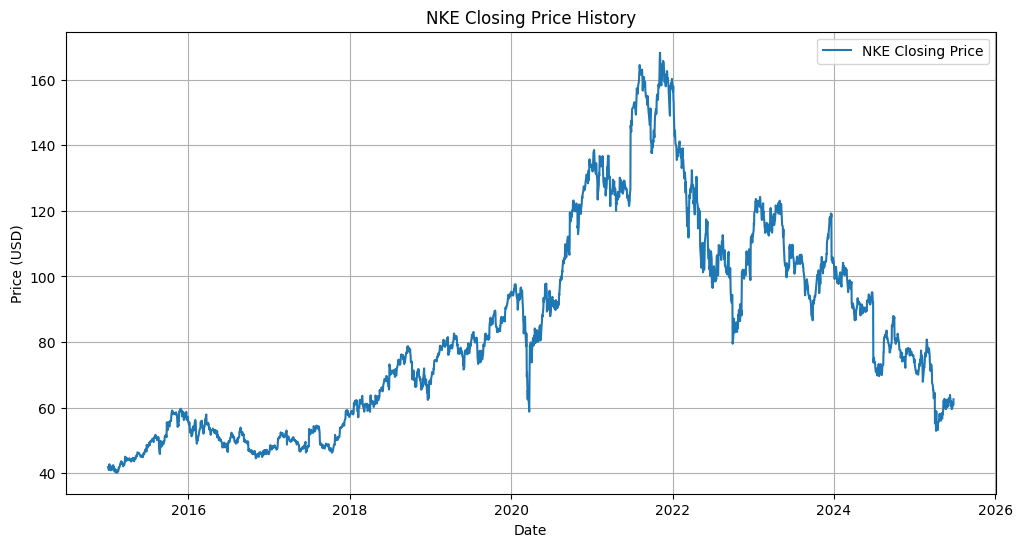

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label=f"{ticker} Closing Price")
plt.title(f"{ticker} Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

plt.show()

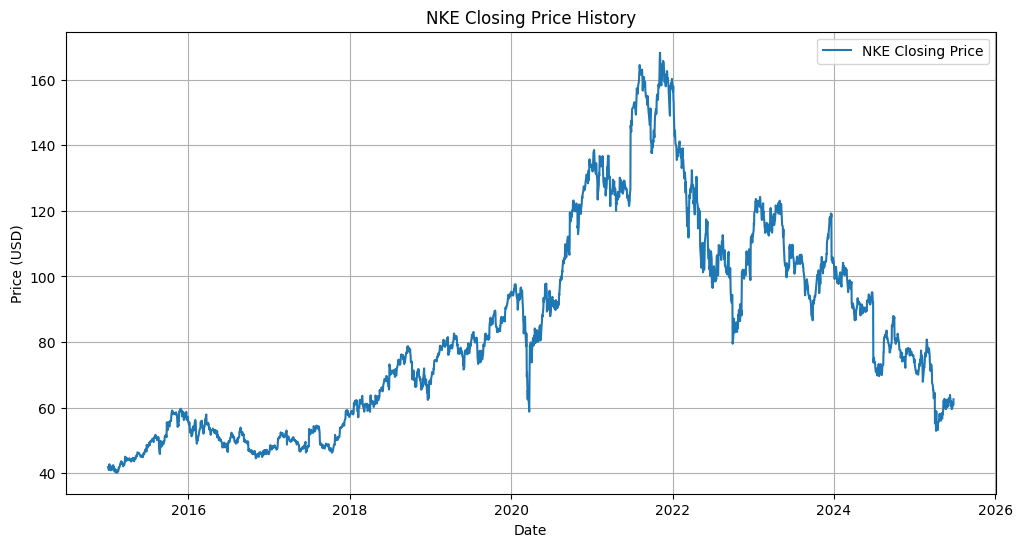

In [17]:
close_prices = df[['Close']].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label=f"{ticker} Closing Price")
plt.title(f"{ticker} Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

plt.show()

In [24]:
def create_sequences(data, window_size):
    X = []
    Y = []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        Y.append(data[i, 0])
    
    return np.array(X), np.array(Y)


slider_size = 60
X, Y = create_sequences(scaled_close, slider_size)

X = X.reshape((X.shape[0], X.shape[1], 1))


print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (2576, 60, 1)
Y shape: (2576,)
